In [1]:
%matplotlib inline

In [2]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import pycomlink as pycml

# Rain rate dependent WAA based on Leijnse et al 2008

[Leijnse et al 2008](https://doi.org/10.1016/j.advwatres.2008.03.004) proposes a WAA parametrization based on a thin water film with rain rate dependent thickness on the antenna.

## R vs. WAA relation

Here we look at the resulting WAA for different frequencies and different rain rates 

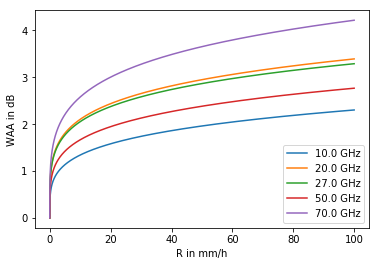

In [3]:
R = np.arange(0, 100, 0.01)

fig, ax = plt.subplots()

for f in [10, 20, 27, 50, 70]:
    waa = pycml.processing.wet_antenna.wet_antenna.waa_leijnse_2008(f_Hz=f*1e9, R=R)
    ax.plot(R, waa, label='%2.1f GHz' % f)
ax.legend()
ax.set_xlabel('R in mm/h')
ax.set_ylabel('WAA in dB')
plt.show()

## A_obs vs. WAA relation

Since CMLs do not directly yield the rain rate `R` we want to derive the WAA from the observed attenuation `A_obs`.

This can be done by deriving the relation between `A_rain` and `waa`, where `A_rain` is calculated from `R` via the A-R relation for a given CML frequency and length. Combining `A_rain` and `waa` we get `A_obs`. In the following we will use this data to build a look-up-table (we actually use an interpolator here) to derive `waa` from any new value of `A_obs`.

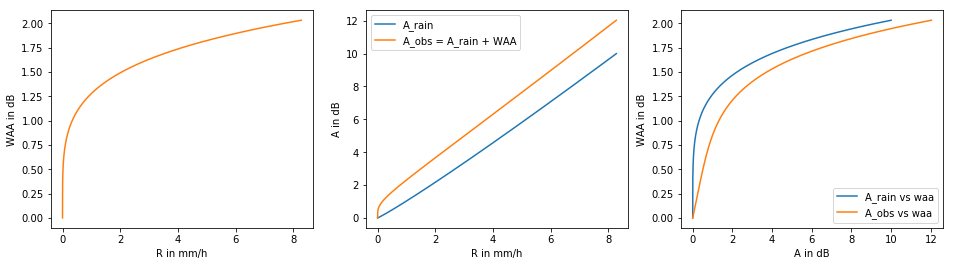

In [4]:
f_GHz = 23.0

A_rain = np.logspace(-11, 1, 1000)
A_rain[0] = 0

R = pycml.processing.A_R_relation.A_R_relation.calc_R_from_A(A_rain, L=10.0, f_GHz=f_GHz, R_min=0)
waa = pycml.processing.wet_antenna.wet_antenna.waa_leijnse_2008(f_Hz=f_GHz*1e9, R=R)
A_obs = A_rain + waa

fig, axs = plt.subplots(1, 3, figsize=(16, 4))
ax = axs[0]
ax.plot(R, waa, color='C1')
ax.set_xlabel('R in mm/h')
ax.set_ylabel('WAA in dB')

ax = axs[1]
ax.plot(R, A_rain, label='A_rain')
ax.plot(R, A_obs, label='A_obs = A_rain + WAA')
ax.set_xlabel('R in mm/h')
ax.set_ylabel('A in dB')
ax.legend()

ax = axs[2]
ax.plot(A_rain, waa, label='A_rain vs waa')
ax.plot(A_obs, waa, label='A_obs vs waa')
ax.set_xlabel('A in dB')
ax.set_ylabel('WAA in dB')
ax.legend();

## Relative contribution of WAA to observed attenuation

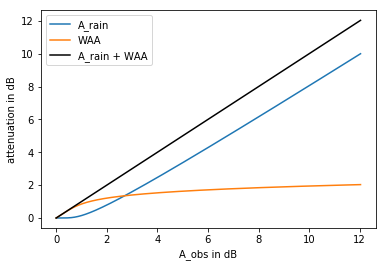

In [5]:
plt.plot(A_obs, A_rain, label='A_rain')
plt.plot(A_obs, waa, label='WAA');
plt.plot(A_obs, A_rain + waa, color='k', label='A_rain + WAA');
plt.xlabel('A_obs in dB')
plt.ylabel('attenuation in dB')
plt.legend();

## Look-up-table function to calculate WAA from A_obs

In [6]:
def waa_from_A_obs(A_obs, L, f_GHz):
    # Generate mapping from A_obs to WAA
    A_rain = np.logspace(-10, 3, 100)
    A_rain[0] = 0
    
    R = pycml.processing.A_R_relation.A_R_relation.calc_R_from_A(A_rain, L=L, f_GHz=f_GHz, R_min=0)
    waa = pycml.processing.wet_antenna.wet_antenna.waa_leijnse_2008(f_Hz=f_GHz*1e9, R=R)
    A_obs_theoretical = A_rain + waa
    
    mapping = scipy.interpolate.interp1d(A_obs_theoretical, waa, assume_sorted=True, kind='linear')
    return mapping(A_obs)

waa_from_A_obs(np.arange(10), L=10, f_GHz=23)

array([0.        , 0.85081045, 1.2087577 , 1.39943582, 1.53099038,
       1.63112499, 1.7142827 , 1.78122755, 1.84301522, 1.89539232])

The same functionality is also available directly in `pycomlink`

In [7]:
pycml.processing.wet_antenna.wet_antenna.waa_leijnse_2008_from_A_obs(np.arange(10), L_km=10, f_Hz=23e9)

array([0.        , 0.85081045, 1.2087577 , 1.39943582, 1.53099038,
       1.63112499, 1.7142827 , 1.78122755, 1.84301522, 1.89539232])

# WAA estimation for real CML data

Get example CML data

In [8]:
cml_list = pycml.io.examples.get_75_cmls()

75 CMLs read in


## Estimate A_rain with the methods from above

/Users/chwala-c/miniconda2/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


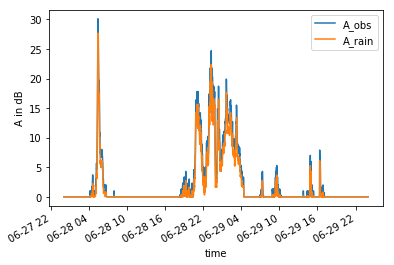

In [9]:
cml = cml_list[0]
df = cml.channel_1.data.copy()

df['wet'] = df.txrx.rolling(60, center=True).std() > 0.8
df['baseline'] = pycml.processing.baseline.baseline.baseline_constant(rsl=df.txrx, wet=df.wet)
df['A_obs'] = df.txrx - df.baseline
df.A_obs.loc[df.A_obs < 0] = 0
df['waa'] = waa_from_A_obs(df.A_obs, 
                           L=cml.metadata['length'], 
                           f_GHz=cml.channel_1.metadata['frequency']/1e9)
df['A_rain'] = df.A_obs - df.waa
df.A_obs.plot(label='A_obs')
df.A_rain.plot(label='A_rain')
plt.ylabel('A in dB')
plt.legend();

## Check if the WAA derived from the look-up-table function fits the WAA from the equations 

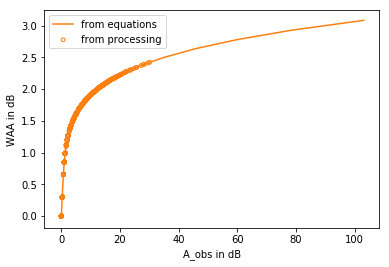

In [10]:
A_rain = np.logspace(-10, 2, 100)
A_rain[0] = 0

R = pycml.processing.A_R_relation.A_R_relation.calc_R_from_A(A_rain, 
                                                            L=cml.metadata['length'], 
                                                            f_GHz=cml.channel_1.metadata['frequency']/1e9,
                                                            R_min=0)
waa = pycml.processing.wet_antenna.wet_antenna.waa_leijnse_2008(f_Hz=cml.channel_1.metadata['frequency'], 
                                                                R=R)
A_obs_theoretical = A_rain + waa

fig, ax = plt.subplots()
ax.plot(A_obs_theoretical, waa, color='C1', label='from equations')
ax.set_xlabel('A_obs in dB')
ax.set_ylabel('WAA in dB')
ax.scatter(df.A_obs, df.waa, color='C1', marker='o', facecolor='None', s=15, label='from processing')
ax.legend();

# Compare WAA from Leijnse et al 2008 and from Schleiss et al 2013

[Schleiss et al 2013](https://ieeexplore.ieee.org/document/6451115) parametrizes the WAA as a function of time, with a defined rise rate to a maximum WAA value.

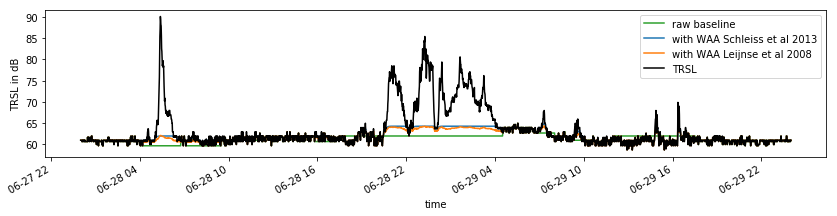

In [25]:
cml = cml_list[0]
df = cml.channel_1.data.copy()

df['wet'] = df.txrx.rolling(60, center=True).std() > 0.6
df['baseline'] = pycml.processing.baseline.baseline.baseline_constant(rsl=df.txrx, 
                                                                      wet=df.wet)
df['A_obs'] = df.txrx - df.baseline
df.A_obs.loc[df.A_obs<0] = 0

df['baseline_waa_schleiss'] = pycml.processing.wet_antenna.wet_antenna.waa_adjust_baseline(rsl=df.txrx, 
                                                                                  baseline=df.baseline, 
                                                                                  wet=df.wet,
                                                                                  waa_max=2.3, 
                                                                                  delta_t=1, 
                                                                                  tau=15)
df['waa_leijnse'] = waa_from_A_obs(df.A_obs,
                                   L=cml.metadata['length'], 
                                   f_GHz=cml.channel_1.metadata['frequency']/1e9)
df['baseline_waa_leijnse'] = df.baseline + df.waa_leijnse
df.baseline_waa_leijnse.loc[df.baseline_waa_leijnse > df.txrx] = df.txrx

fig, ax = plt.subplots(figsize=(14,3))
df.baseline.plot(label='raw baseline', color='C2')
df.baseline_waa_schleiss.plot(label='with WAA Schleiss et al 2013', color='C0')
df.baseline_waa_leijnse.plot(label='with WAA Leijnse et al 2008', color='C1')
df.txrx.plot(color='k', label='TRSL')
plt.ylabel('TRSL in dB')
plt.legend();